In [2]:
import numpy as np
import scipy, h5py
import scipy.stats as stats
import os,sys
import tables
import scipy.io as scio
import matplotlib.pyplot as plt
import uproot, argparse
from scipy.optimize import minimize
from scipy import interpolate
from numpy.polynomial import legendre as LG
from scipy import special
import warnings

In [3]:
warnings.filterwarnings('ignore')

h = tables.open_file('../../calib/Time_coeff.h5','r')
coeff = h.root.coeff[:]
h.close()
cut, fitcut = coeff.shape

# physical constant
Light_yield = 4285*0.88 # light yield
Att_LS = 18 # attenuation length of LS
Att_Wtr = 300 # attenuation length of water
tau_r = 1.6 # fast time constant
TTS = 5.5/2.355
QE = 0.20
PMT_radius = 0.254
c = 2.99792e8
n = 1.48
shell = 12 # Acrylic

In [22]:
def Likelihood_Time(vertex, *args):
    coeff, PMT_pos, fired, time, cut = args
    y = time
    # fixed axis
    z = np.sqrt(np.sum(vertex[1:4]**2))/12.2
    cos_theta = np.sum(vertex[1:4]*PMT_pos,axis=1)\
        /np.sqrt(np.sum(vertex[1:4]**2)*np.sum(PMT_pos**2,axis=1))
    # accurancy and nan value
    cos_theta = np.nan_to_num(cos_theta)
    cos_theta[cos_theta>1] = 1
    cos_theta[cos_theta<-1] =-1

    cos_total = cos_theta[fired]
    
    size = np.size(cos_total)
    x = np.zeros((size, cut))
    # legendre coeff
    for i in np.arange(0,cut):
        c = np.zeros(cut)
        c[i] = 1
        x[:,i] = LG.legval(cos_total,c)

    k = np.zeros((1,cut))
    for i in np.arange(cut):
        # cubic interp
        k[0,i] = np.sum(np.polynomial.legendre.legval(z,coeff[i,:]))
    
    #k[0] = k[0] + np.log(vertex[0])
    k[0,0] = vertex[0]
    T_i = np.dot(x, np.transpose(k))
    #L = Likelihood_quantile(y, T_i[:,0], 0.01, 0.3)
    L = - np.nansum(TimeProfile(y, T_i[:,0]))
    return L, T_i[:,0]

In [5]:
def Likelihood_quantile(y, T_i, tau, ts):
    less = T_i[y<T_i] - y[y<T_i]
    more = y[y>=T_i] - T_i[y>=T_i]

    R = (1-tau)*np.sum(less) + tau*np.sum(more)
    #log_Likelihood = exp
    return R

In [6]:
def TimeProfile(y,T_i):
    time_correct = y - T_i
    time_correct[time_correct<=-8] = -8
    plt.hist(time_correct, bins=100)
    p_time = TimeUncertainty(time_correct, 26)
    return p_time

In [7]:
def TimeUncertainty(tc, tau_d):
    TTS = 2.2
    tau_r = 1.6
    a1 = np.exp(((TTS**2 - tc*tau_d)**2-tc**2*tau_d**2)/(2*TTS**2*tau_d**2))
    a2 = np.exp(((TTS**2*(tau_d+tau_r) - tc*tau_d*tau_r)**2 - tc**2*tau_d**2*tau_r**2)/(2*TTS**2*tau_d**2*tau_r**2))
    a3 = np.exp(((TTS**2 - tc*tau_d)**2 - tc**2*tau_d**2)/(2*TTS**2*tau_d**2))*special.erf((tc*tau_d-TTS**2)/(np.sqrt(2)*tau_d*TTS))
    a4 = np.exp(((TTS**2*(tau_d+tau_r) - tc*tau_d*tau_r)**2 - tc**2*tau_d**2*tau_r**2)/(2*TTS**2*tau_d**2*tau_r**2))*special.erf((tc*tau_d*tau_r-TTS**2*(tau_d+tau_r))/(np.sqrt(2)*tau_d*tau_r*TTS))
    p_time  = np.log(tau_d + tau_r) - 2*np.log(tau_d) + np.log(a1-a2+a3-a4)
    return p_time

In [8]:
def con_sph(args):
    E_min,\
    E_max,\
    tau_min,\
    tau_max,\
    t0_min,\
    t0_max\
    = args
    cons = ({'type': 'ineq', 'fun': lambda x: shell**2 - (x[1]**2 + x[2]**2 + x[3]**2)})
    return cons

In [15]:
def ReadPMT():
    f = open(r"../PMT_5kt.txt")
    line = f.readline()
    data_list = [] 
    while line:
        num = list(map(float,line.split()))
        data_list.append(num)
        line = f.readline()
    f.close()
    PMT_pos = np.array(data_list)
    PMT_pos = PMT_pos[:,1:4]
    return PMT_pos

[[ 2.75092579e+02 -7.50675676e-02  5.95945946e-03 -1.89189189e-02]] [[0. 0. 0. 0.]]


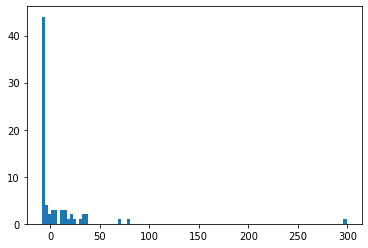

In [25]:
PMT_pos = ReadPMT()
event_count = 0
fid = '/mnt/stage/douwei/Simulation/5kt_root/2MeV_h5/5kt_+0.00.h5'
# Loop for event

h = tables.open_file(fid,'r')
rawdata = h.root.GroundTruth
EventID = rawdata[:]['EventID']
ChannelID = rawdata[:]['ChannelID'] - 1
Time = rawdata[:]['PETime']

for i in np.arange(1):
    event_count = event_count + 1
    index = (EventID==event_count)
    pe_array = np.zeros(np.size(PMT_pos[:,1])) # Photons on each PMT (PMT size * 1 vector)
    fired_PMT = ChannelID[index]
    for j in np.arange(np.size(fired_PMT)):
        pe_array[fired_PMT[j]] = pe_array[fired_PMT[j]]+1

    time_array = Time[index]        
    fired_PMT = fired_PMT.astype(int)
    # initial result
    result_vertex = np.empty((0,6)) # reconstructed vertex
    # initial value x[0] = [1,6]

    # Constraints
    E_min = 0.01
    E_max = 10
    tau_min = 0.01
    tau_max = 100
    t0_min = -300
    t0_max = 300

    # initial value
    x0 = np.zeros((1,4))
    x0[0][0] = np.mean(time_array)
    x0[0][1] = np.sum(pe_array*PMT_pos[:,0])/np.sum(pe_array)/1e3
    x0[0][2] = np.sum(pe_array*PMT_pos[:,1])/np.sum(pe_array)/1e3
    x0[0][3] = np.sum(pe_array*PMT_pos[:,2])/np.sum(pe_array)/1e3
    
    con_args = E_min, E_max, tau_min, tau_max, t0_min, t0_max
    cons_sph = con_sph(con_args)
    record = np.zeros((1,4))
    print(x0)
    L1, T_i1 = Likelihood_Time(np.array([284.86790049,5.41700065,-2.56592721,-1.20187376]), *(coeff, PMT_pos, fired_PMT, time_array, cut))
    L2, T_i2 = Likelihood_Time(np.array([284.86790049,0,0,0]), *(coeff, PMT_pos, fired_PMT, time_array, cut))

In [44]:
print(L1,L2)

2413.3159905851226 1973.2750443847779


In [42]:
print(coeff[:,0])
print(coeff[0,:])

[ 1.73347729e+02  8.92305896e-03 -4.88643163e+00 -7.21482326e-03
 -1.40694634e+00]
[1.73347729e+02 9.98137753e-03 1.17096197e+01 1.99203982e-02
 7.58599925e-03 2.62765547e-02 1.96977249e-01]


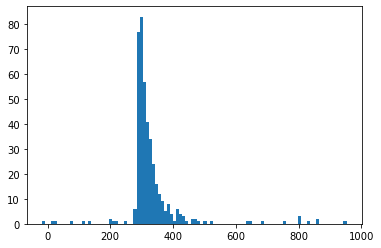

In [47]:
plt.hist(time_array,bins=100)
plt.show()